# Spot Price Forecasting

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import tqdm

from utils import *
from latexify import *
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = 5

## Training and test data sets

In [2]:
price_data = pd.read_csv('data/spot_prices.csv', parse_dates=[0], index_col=0)["Spot Price (NOK/kWh)"]

# Split data into train set and test set
train = price_data[price_data.index.year <= 2021]
test = price_data[price_data.index.year == 2022]

## Seasonal baseline forecast

In [3]:
def featurize_baseline(t):
    # Define the fundamental periods
    P1, P2, P3 = 24*1, 24*7, 24*365

    # Generate harmonics
    harmonics_P1 = [P1/n for n in range(1, 5)]
    harmonics_P2 = [P2/n for n in range(1, 5)]
    harmonics_P3 = [P3/n for n in range(1, 5)]
    
    # Initialize an empty list to store the features
    features = []

    # Add the number 1
    features.append(1)

    # Add Fourier terms for each harmonic
    for h in harmonics_P1 + harmonics_P2 + harmonics_P3:
        features.append(np.sin(2 * np.pi * t / h))
        features.append(np.cos(2 * np.pi * t / h))

    return features

def RMSE(X, Y, theta):
    return (1.0 / X.shape[0]) * np.linalg.norm(X @ theta - Y)**2

X_train = np.array([featurize_baseline(t) for t in range(len(train))])
Y_train = train.values
X_test = np.array([featurize_baseline(t) for t in range(len(train), len(train)+len(test))])
Y_test = test.values

# Specify quantile regression problem
theta = cp.Variable(X_train.shape[1])
tau, lambd = cp.Parameter(nonneg=True), cp.Parameter(nonneg=True)
sqrt_mu = np.array([1, 2, 3, 4]*6)
loss = cp.sum(0.5 * cp.abs(X_train @ theta - Y_train) + (tau - 0.5) * X_train @ theta - Y_train)
reg = lambd * cp.sum_squares(cp.multiply(sqrt_mu, theta[1:]))
problem = cp.Problem(cp.Minimize(loss))

# Solve problem
tau.value, lambd.value = 0.5, 0.1
problem.solve(solver=cp.MOSEK)

train_RMSE = RMSE(X_train,Y_train, theta.value)
test_RMSE = RMSE(X_test, Y_test, theta.value)

print('Baseline train RMSE', train_RMSE)
print('Baseline test RMSE', test_RMSE)

train_baseline = X_train @ theta.value
test_baseline = X_test @ theta.value

train_baseline_series = pd.Series(index=train.index, data=train_baseline)
test_baseline_series = pd.Series(index=test.index, data=test_baseline)

# Extend test baseline one year and save
X_aug = np.array([featurize_baseline(t) for t in range(len(train), len(train)+2*len(test))])
baseline = X_aug @ theta.value
date_range = pd.date_range(start='2022-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H', tz=None)
baseline = pd.Series(data=baseline, index=date_range)
baseline = pd.concat([train_baseline_series, baseline])
baseline.to_csv("data/spot_price_baseline.csv", header=["Baseline spot price (NOK/kWh)"])

Baseline train RMSE 0.068243700618497
Baseline test RMSE 0.5068854927885422


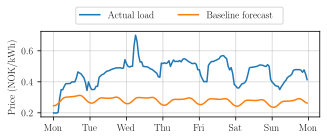

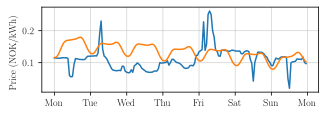

In [4]:
# Plot load and seasonal baseline for first week of January 2022
latexify(fig_width=fig_width, fig_height=fig_width*golden_mean/2)
fig, ax = plt.subplots()
plt.plot(test.loc['2022-01-03':'2022-01-09'].values, color="tab:blue", label="Actual load")
plt.plot(test_baseline_series.loc['2022-01-03':'2022-01-09'].values, color="tab:orange", label="Baseline forecast")
legend = ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.51, 0.9), bbox_transform=plt.gcf().transFigure)
plt.ylabel("Price (NOK/kWh)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

plt.savefig("figures/price_baseline_jan.pdf")

# Plot load and seasonal baseline for first week of July 2022
latexify(fig_width=fig_width, fig_height=fig_width*golden_mean/2)
fig, ax = plt.subplots()
plt.plot(test.loc['2022-06-06':'2022-06-12'].values, color="tab:blue", label="Actual load")
plt.plot(test_baseline_series.loc['2022-06-06':'2022-06-12'].values, color="tab:orange", label="Baseline forecast")
plt.ylabel("Price (NOK/kWh)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

plt.savefig("figures/price_baseline_jul.pdf")

## Auto-regressive residual forecast

In [5]:
train_residual = train - train_baseline
test_residual = test - test_baseline

M, L = 24, 23

def featurize_residual(obs, M, L):
    X = np.zeros((len(obs) - M - L+1, M))
    for i in range(M):
        X[:,i] = obs[M-i-1:-L-i]
        
    y = np.zeros((len(obs) - M - L+1, L))
    for i in range(L):
        y[:,i] = obs[M+i:len(obs)+1-L+i]
        
    return X, y

# Featurize residuals
Xtr, ytr = featurize_residual(train_residual, M, L)
Xte, yte = featurize_residual(test_residual, M, L)

# Specify quantle regression problem to fit AR parameters
AR_params_var = cp.Variable((M,L))
tau, lambd = cp.Parameter(nonneg=True), cp.Parameter(nonneg=True)
loss = cp.sum(0.5 * cp.abs(Xtr @ AR_params_var - ytr) + (tau - 0.5) * Xtr @ AR_params_var - ytr)
reg = lambd * cp.sum_squares(AR_params_var)
problem = cp.Problem(cp.Minimize(loss + reg))

# Solve problem
tau.value, lambd.value = 0.5, 0.1
problem.solve(solver=cp.MOSEK)
AR_params = AR_params_var.value

# Save AR parameters
pd.to_pickle(AR_params, "data/spot_price_AR_params.pickle")

## Forecast comparison for a test day

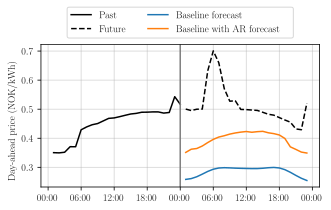

In [6]:
test_day = pd.to_datetime(datetime.datetime(2022, 1, 5))
past = test[test.index <= test_day][-M:]
past_baseline = test_baseline[test.index <= test_day][-M:]

future = test[test.index > test_day][:L]
future_baseline = test_baseline[test.index > test_day][:L]

past_res = past - past_baseline
future_res_prediction = past_res.values @ AR_params
future_res = future - future_baseline

latexify(fig_width=fig_width, fig_height=fig_width*golden_mean/1.2)
plt.figure()

# Plot past data
plt.plot(past.index, past.values, color="k", label="Past")
plt.axvline(test_day, color='gray')

# Plot future data
plt.plot(future.index, future.values, color="k", linestyle="dashed",label="Future")
plt.plot(future.index, future_baseline, color="tab:blue", label="Baseline forecast")
plt.plot(future.index, future_baseline + future_res_prediction, color="tab:orange", label="Baseline with AR forecast")

plt.ylabel("Day-ahead price (NOK/kWh)")
# plt.legend(ncol=2)
plt.legend(bbox_to_anchor=(0.5, 1.01), loc='lower center', ncol=2)

# Format x-axis datetime
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.savefig("figures/price_forecast_comparison.pdf")